# Transfer Learning for CNNs: Leveraging Pre-trained Models

**Transfer learning is a machine learning technique where a pre-trained model is used as a starting point for a new task. In the context of convolutional neural networks (CNNs), this means using a CNN that has been trained on a large dataset for one task (e.g., ImageNet) as a foundation for a new task (e.g., classifying medical images).**

**Why Transfer Learning?**

- **Reduced Training Time:** Training a CNN from scratch on a large dataset can be computationally expensive and time-consuming. Transfer learning allows you to leverage the knowledge learned by the pre-trained model, reducing training time significantly.
- **Improved Performance:** Pre-trained models have often been trained on massive datasets, allowing them to learn general-purpose features that can be useful for a wide range of tasks. Using these pre-trained models can improve the performance of your new task.
- **Smaller Datasets:** Transfer learning can be particularly useful when you have a small dataset for your new task. By using a pre-trained model, you can augment your limited data with the knowledge learned from the larger dataset.

**How Transfer Learning Works:**

- **Choose a Pre-trained Model:** Select a pre-trained CNN that is suitable for your task. Common choices include VGG16, ResNet, InceptionV3, and EfficientNet.
- **Freeze Layers:** Typically, the earlier layers of a CNN learn general-purpose features, while the later layers learn more task-specific features. You can freeze the earlier layers of the pre-trained model to prevent them from being updated during training. This helps to preserve the learned features.
- **Add New Layers:** Add new layers, such as fully connected layers or convolutional layers, to the end of the pre-trained model. These layers will be trained on your new dataset to learn task-specific features.
- **Fine-tune:** Train the new layers on your dataset while keeping the frozen layers fixed. This process is called fine-tuning.

**Common Transfer Learning Scenarios:**

- **Feature Extraction:** Extract features from the pre-trained model and use them as input to a different model, such as a support vector machine (SVM) or a random forest.
- **Fine-tuning:** Fine-tune the pre-trained model on your new dataset to adapt it to your specific task.
- **Hybrid Approach:** Combine feature extraction and fine-tuning by extracting features from the pre-trained model and using them as input to a new model, while also fine-tuning some layers of the pre-trained model.

**Transfer learning is a powerful technique that can significantly improve the performance and efficiency of CNNs, especially when working with limited datasets or time constraints.**

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  Distributed Computing
import tensorflow as tf


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers

In [3]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [4]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [5]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = "brain-tumor-classification-mri/Training", 
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')

Found 2870 images belonging to 4 classes.
Data Augmentation 1 was used to generate train data set



In [6]:
test_generator = data_generator_3.flow_from_directory(
    directory = "brain-tumor-classification-mri/Testing", 
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 394 images belonging to 4 classes.


In [7]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Class labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


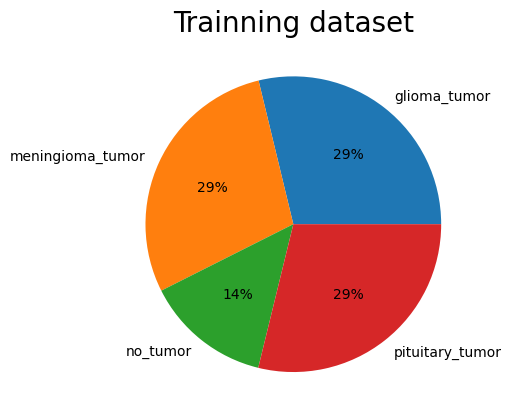

In [8]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [9]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set ----> \n")
print("Number of images:", len(train_generator1.classes))
print("Number of glioma_tumor images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of meningioma_tumor images:", len([label for label in train_generator1.classes if label == 1]))
print("Number of no_tumor images:", len([label for label in train_generator1.classes if label == 2]))
print("Number of pituitary_tumor images:", len([label for label in train_generator1.classes if label == 3]))
print()

# Dataset characteristics
print("Dataset Characteristics of Test Data Set ----> \n")
print("Number of images:", len(test_generator.classes))
print("Number of glioma_tumor images:", len([label for label in test_generator.classes if label == 0]))
print("Number of meningioma_tumor images:", len([label for label in test_generator.classes if label == 1]))
print("Number of no_tumor images:", len([label for label in test_generator.classes if label == 2]))
print("Number of pituitary_tumor images:", len([label for label in test_generator.classes if label == 3]))
print()

Dataset Characteristics of Train Data Set ----> 

Number of images: 2870
Number of glioma_tumor images: 826
Number of meningioma_tumor images: 822
Number of no_tumor images: 395
Number of pituitary_tumor images: 827

Dataset Characteristics of Test Data Set ----> 

Number of images: 394
Number of glioma_tumor images: 100
Number of meningioma_tumor images: 115
Number of no_tumor images: 105
Number of pituitary_tumor images: 74



In [10]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 0.8686440677966102,
 1: 0.8728710462287105,
 2: 1.8164556962025316,
 3: 0.8675937122128174}

Train image data from Data Augmentation 1


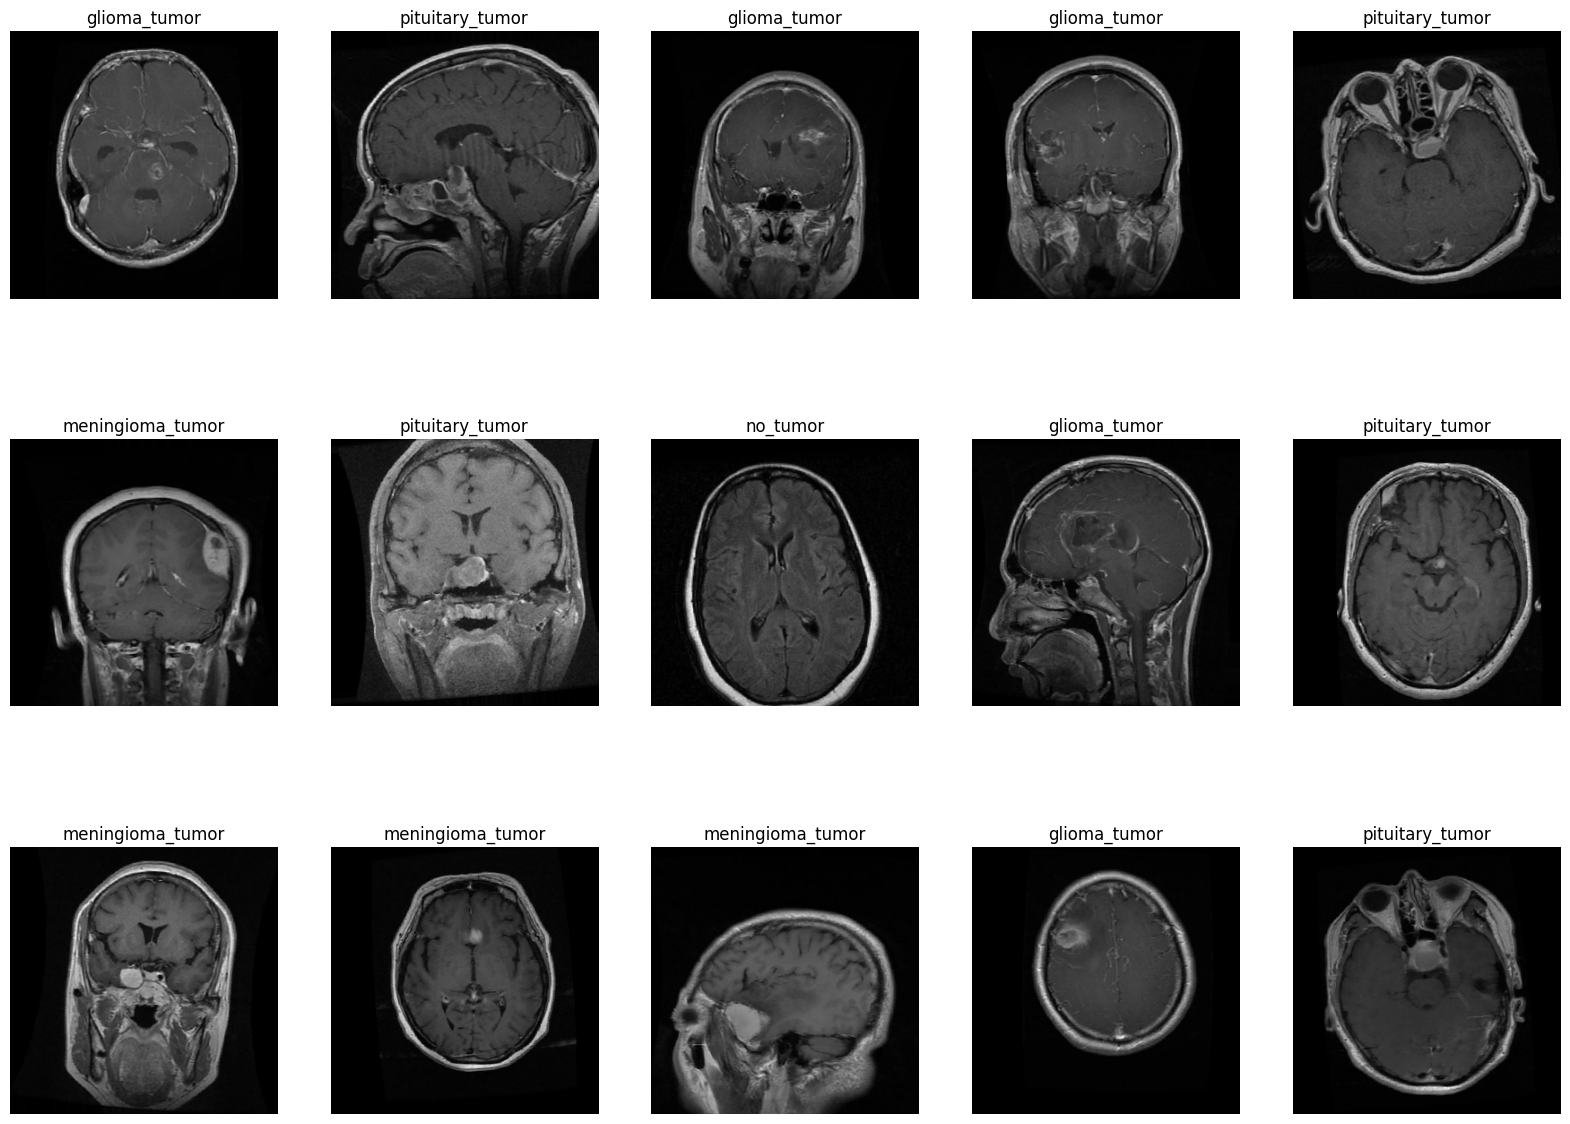

In [11]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[20, 15])
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

# Convolutional neural networks (CNNs)

In [12]:
# Define the epochs for training 
EPOCHS = 5

# Define the number of GPUs to use
num_gpus = 2

# Merge augmented image data for training
# merged_train_generator = chain(train_generator1, train_generator2, train_generator3)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

# For development purpose, we first limit the train data set to the original image data set
# train_data = merged_train_generator
# train_data = train_generator1
train_data = train_generator1
# train_data = test_generator

<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 VGG16 🎲</span>

**VGG16 is a convolutional neural network (CNN) architecture that was introduced in 2014. It was developed by researchers from the University of Oxford and is known for its simplicity and effectiveness in image classification tasks.**

**Key features of VGG16:**

- **Simple Architecture:** VGG16 uses a stack of 16 convolutional layers, followed by three fully connected layers and a final softmax layer for classification.
- **Small Filters:** The convolutional layers in VGG16 use small 3x3 filters, which are repeated multiple times to increase the depth of the network.
- **Uniform Stride:** The convolutional layers use a uniform stride of 1, which means that the filters are applied to every pixel in the input image.
- **Max Pooling:** After each block of convolutional layers, a max pooling layer is used to reduce the spatial dimensions of the feature maps.

**Benefits of VGG16:**

- **Simplicity:** VGG16's architecture is relatively simple and easy to understand, making it a popular choice for researchers and practitioners.
- **Effectiveness:** VGG16 achieved state-of-the-art performance on the ImageNet classification dataset when it was introduced, demonstrating its effectiveness in image classification tasks.
- **Pre-trained Models:** Pre-trained VGG16 models are widely available, which can be used as a starting point for transfer learning tasks in other domains.

**Applications of VGG16:**

- **Image Classification:** VGG16 is commonly used for image classification tasks, such as object recognition, scene classification, and facial recognition.
- **Transfer Learning:** VGG16 can be used as a feature extractor for transfer learning tasks, where the pre-trained model is fine-tuned on a smaller dataset to solve a related task.
- **Object Detection:** VGG16 has been used as a component of object detection architectures, such as Faster R-CNN and SSD.

**In summary, VGG16 is a powerful and versatile CNN architecture that has made significant contributions to the field of computer vision. Its simplicity, effectiveness, and availability of pre-trained models make it a popular choice for various image classification and transfer learning tasks.**

<center> <img src="https://www.researchgate.net/profile/Mengyun-Liu-4/publication/327060416/figure/fig1/AS:660427612622849@1534469621448/Architecture-of-VGG16.png" width="1000" height="300"> </center>

In [13]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [14]:
# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained VGG16 model without the top classification layer
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_VGG16.layers:
        layer.trainable = False
    
# Create a new model and add the VGG16 base model
model_VGG16 = Sequential()
model_VGG16.add(base_model_VGG16)

# Add a fully connected layer and output layer for classification
model_VGG16.add(GlobalAveragePooling2D())
model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.4))
model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.2))
model_VGG16.add(Dense(4, activation='softmax'))

In [15]:
# Model summary
print("Model Summary (VGG16):")
model_VGG16.summary()
print()

Model Summary (VGG16):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,868 (56.42 MB)

 Trainable params: 74,180 (289.77 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Compile the model
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, 
                                validation_data=test_generator, 
                                callbacks=[early_stopping], 
                                class_weight=class_weights) 

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step - accuracy: 0.2927 - loss: 1.6512 - val_accuracy: 0.4010 - val_loss: 1.5147
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 555s 9s/step - accuracy: 0.5201 - loss: 1.2623 - val_accuracy: 0.3731 - val_loss: 1.8195
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 545s 9s/step - accuracy: 0.6090 - loss: 1.0229 - val_accuracy: 0.4010 - val_loss: 1.8235
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [18]:
# Validate the model
val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_VGG16:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.4106 - loss: 1.4966
Validation Loss: 1.5147
Validation Accuracy: 0.4010


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 MobileNetV2 🎲 </span>

**MobileNetV2 is a convolutional neural network (CNN) architecture designed specifically for mobile and embedded vision applications. It was introduced in 2018 and is known for its high efficiency and accuracy.**

**Key features of MobileNetV2:**

- **Inverted Residual Blocks:** MobileNetV2 uses inverted residual blocks as the building blocks of its architecture. These blocks consist of a 1x1 expansion layer, a depthwise separable convolution, a 1x1 projection layer, and a residual connection.
- **Depthwise Separable Convolutions:** Depthwise separable convolutions are a key component of MobileNetV2. They decompose the standard convolution operation into two separate operations: depthwise convolutions and pointwise convolutions. This decomposition significantly reduces the number of parameters and computations.
- **Pointwise Convolutions:** Pointwise convolutions are used to combine the features produced by the depthwise convolutions. They are equivalent to 1x1 convolutions.
- **ReLU6 Activation:** MobileNetV2 uses the ReLU6 activation function, which is a variant of the ReLU function with a maximum value of 6. This helps to prevent the vanishing gradient problem.

**Benefits of MobileNetV2:**

- **High Efficiency:** MobileNetV2 is designed to be highly efficient, making it suitable for mobile and embedded devices with limited computational resources.
- **High Accuracy:** Despite its efficiency, MobileNetV2 achieves state-of-the-art accuracy on a variety of image classification benchmarks.
- **Transfer Learning:** MobileNetV2 can be used for transfer learning, where the pre-trained model is fine-tuned on a smaller dataset to solve a related task.

**Applications of MobileNetV2:**

- **Mobile Vision:** MobileNetV2 is widely used in mobile vision applications, such as object detection, image classification, and facial recognition.
- **Embedded Vision:** MobileNetV2 can be deployed on embedded devices, such as drones and robots, for tasks like real-time object tracking and scene understanding.
- **Edge Computing:** MobileNetV2 is well-suited for edge computing applications, where models are deployed on devices at the edge of the network to reduce latency and bandwidth requirements.

**In summary, MobileNetV2 is a highly efficient and accurate CNN architecture that is specifically designed for mobile and embedded vision applications. Its inverted residual blocks, depthwise separable convolutions, and pointwise convolutions make it a popular choice for developers working on resource-constrained devices.**

<center> <img src="https://www.researchgate.net/publication/344147751/figure/fig1/AS:937300028579842@1600481149525/The-structure-of-the-MobileNet-v2-dense-network-Where-the-block-names-correspond-to.png" width="1000" height="300"> </center>

In [19]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_MobileNet.layers:
    layer.trainable = False
    
# Create a new model and add the MobileNetV2 base model
model_MobileNet = Sequential()
model_MobileNet.add(base_model_MobileNet)

# Add a global average pooling layer and output layer for classification
model_MobileNet.add(GlobalAveragePooling2D())
model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.4))
model_MobileNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.2))
model_MobileNet.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (MobileNetV2):")
model_MobileNet.summary()
print()

   

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (MobileNetV2):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
 # Compile the model
model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4514 - loss: 1.4854 - val_accuracy: 0.4213 - val_loss: 2.0545
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7541 - loss: 0.8387 - val_accuracy: 0.4772 - val_loss: 1.8979
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7979 - loss: 0.7332 - val_accuracy: 0.4822 - val_loss: 1.9294
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8375 - loss: 0.6113 - val_accuracy: 0.5228 - val_loss: 1.9526
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8443 - loss: 0.5742 - val_accuracy: 0.5305 - val_loss: 1.8258
Restoring model weights from the end of the best epoch: 5.


In [21]:
# Validate the model
val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step - accuracy: 0.5157 - loss: 1.7679
Validation Loss: 1.8258
Validation Accuracy: 0.5305


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 DenseNet 🎲 </span>

**DenseNet, introduced in 2017, is a convolutional neural network (CNN) architecture known for its efficient use of parameters and its ability to achieve high accuracy with relatively fewer layers. Unlike traditional CNNs, where each layer's output is passed to the next layer, DenseNet connects every layer to every other layer after it. This dense connectivity pattern enhances information flow and gradient propagation, leading to improved performance.**

***Key Features of DenseNet:***

**1. Dense Connectivity:**

    - Every layer is connected to every other layer after it.
    - This creates a dense highway network, where features from earlier layers are reused by later layers.
    - This helps to alleviate the vanishing gradient problem and enhances information flow.
    
**2. Growth Rate (k):**

    - Each layer adds k new feature maps to the network.
    - The growth rate controls the network's depth and width.
    - A small growth rate can lead to a more compact network, while a larger growth rate can result in a deeper network.
    
**3. Transition Layers:**

    - Transition layers are used to reduce the number of feature maps and the spatial dimensions of the network.
    - They typically consist of a batch normalization layer, a 1x1 convolution, and a 2x2 average pooling layer.
    
**Benefits of DenseNet:**

- **Efficient Parameter Usage:** DenseNet can achieve high accuracy with fewer parameters compared to traditional CNNs.
- **Improved Information Flow:** The dense connectivity pattern helps to propagate information more effectively through the network, leading to better gradient flow and reduced vanishing gradient problems.
- **Feature Reuse:** Features from earlier layers are reused by later layers, which can help to improve the network's ability to learn complex patterns.
- **Reduced Overfitting:** The dense connectivity pattern can help to reduce overfitting by encouraging feature reuse and preventing the network from learning redundant features.

**Applications of DenseNet:**

- **Image Classification:** DenseNet has been successfully used for various image classification tasks, such as ImageNet classification and fine-grained object recognition.
- **Object Detection:** DenseNet has been incorporated into object detection architectures like Faster R-CNN and SSD.
- **Semantic Segmentation:** DenseNet has been applied to semantic segmentation tasks, where the goal is to assign a semantic label to each pixel in an image.

**In conclusion, DenseNet is a powerful and efficient CNN architecture that has made significant contributions to the field of computer vision. Its dense connectivity pattern and efficient parameter usage make it a popular choice for various image analysis tasks.**



<center> <img src="https://th.bing.com/th/id/OIP.5YOWbKvFIaBzEQBXR0XEhAHaC5?rs=1&pid=ImgDetMain" width="1000" height="300"> </center>

In [22]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained DenseNet121 model without the top classification layer
base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_DenseNet.layers:
    layer.trainable = False  
    
# Create a new model and add the DenseNet121 base model
model_DenseNet = Sequential()
model_DenseNet.add(base_model_DenseNet)

# Add a global average pooling layer and output layer for classification
model_DenseNet.add(GlobalAveragePooling2D())
model_DenseNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet.add(Dropout(0.4))
model_DenseNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_DenseNet.add(Dropout(0.2))    
model_DenseNet.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (DenseNet121):")
model_DenseNet.summary()
print()   

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (DenseNet121):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 9, 9, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,177,220 (27.38 MB)

 Trainable params: 139,716 (545.77 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
# Compile the model
model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_DenseNet = model_DenseNet.fit(train_data, 
                                      epochs=EPOCHS, 
                                      validation_data=test_generator, 
                                      callbacks=[early_stopping], 
                                      class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.3943 - loss: 1.7240 - val_accuracy: 0.4315 - val_loss: 1.8464
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7038 - loss: 0.8912 - val_accuracy: 0.4772 - val_loss: 1.5441
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [24]:
 # Validate the model
val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4162 - loss: 1.9013
Validation Loss: 1.8464
Validation Accuracy: 0.4315


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 InceptionV3 🎲 </span>

**InceptionV3 is a convolutional neural network (CNN) architecture introduced in 2015 that is known for its depth, width, and computational efficiency. It builds upon the ideas of the Inception modules introduced in earlier Inception versions, incorporating several enhancements to improve performance.**

**Key Features of InceptionV3:**

- **Inception Modules:** The core building block of InceptionV3 is the Inception module. It consists of a parallel combination of different convolutional filters with different sizes (1x1, 3x3, 5x5) and a pooling layer. This allows the network to capture features at different scales.
- **Factorization:** InceptionV3 uses a factorization technique to decompose 5x5 convolutions into two 3x3 convolutions. This reduces the computational cost while maintaining performance.
- **Label Smoothing:** To regularize the network and prevent overfitting, InceptionV3 uses label smoothing. This technique assigns a small probability to incorrect classes, forcing the network to be less confident in its predictions.
- **Auxiliary Classifiers:** To improve training stability, InceptionV3 includes auxiliary classifiers at intermediate layers. These classifiers help to guide the training process, especially in the early stages.

**Benefits of InceptionV3:**

- **High Accuracy:** InceptionV3 has achieved state-of-the-art performance on various image classification benchmarks, including ImageNet.
- **Computational Efficiency:** The factorization technique and auxiliary classifiers help to improve the computational efficiency of the network.
- **Flexibility:** The Inception modules allow the network to capture features at different scales, making it more flexible and adaptable to various image tasks.

**Applications of InceptionV3:**

- **Image Classification:** InceptionV3 is widely used for image classification tasks, such as object recognition, scene classification, and fine-grained categorization.
- **Object Detection:** InceptionV3 has been incorporated into object detection architectures like Faster R-CNN and SSD.
- **Semantic Segmentation:** InceptionV3 has been applied to semantic segmentation tasks, where the goal is to assign a semantic label to each pixel in an image.

**In conclusion, InceptionV3 is a powerful and efficient CNN architecture that has made significant contributions to the field of computer vision. Its Inception modules, factorization techniques, and auxiliary classifiers make it a popular choice for various image analysis tasks.**

<center> <img src="https://www.jeremyjordan.me/content/images/2018/04/inception-model.png" width="1000" height="300"> </center>

In [25]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained InceptionV3 model without the top classification layer
base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_Inception.layers:
        layer.trainable = False  
        
# Create a new model and add the InceptionV3 base model
model_Inception = Sequential()
model_Inception.add(base_model_Inception)

# Add a global average pooling layer and output layer for classification
model_Inception.add(GlobalAveragePooling2D())
model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.4))
model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.2))
        
model_Inception.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (InceptionV3):")
model_Inception.summary()
print()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (InceptionV3):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,073,572 (84.20 MB)

 Trainable params: 270,788 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [26]:
# Compile the model
model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, 
                                        validation_data=test_generator, 
                                        callbacks=[early_stopping], 
                                        class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.4600 - loss: 1.5012 - val_accuracy: 0.4746 - val_loss: 1.8369
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7245 - loss: 0.9436 - val_accuracy: 0.5406 - val_loss: 1.4683
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7738 - loss: 0.7839 - val_accuracy: 0.5406 - val_loss: 1.4419
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7956 - loss: 0.7031 - val_accuracy: 0.5533 - val_loss: 1.4892
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7923 - loss: 0.6734 - val_accuracy: 0.6497 - val_loss: 1.1958
Restoring model weights from the end of the best epoch: 5.


In [27]:
# Validate the model
val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6249 - loss: 1.2626
Validation Loss: 1.1958
Validation Accuracy: 0.6497


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 ResNet 🎲 </span>

**ResNet (Residual Network), introduced in 2015, is a type of convolutional neural network (CNN) architecture that has significantly impacted the field of deep learning. The key innovation in ResNet is the introduction of residual blocks, which allow the network to learn residual functions instead of the entire underlying mapping. This enables the training of extremely deep networks without suffering from the vanishing gradient problem.**

**Residual Blocks:**

- **Identity Mapping:** A residual block consists of a stack of layers followed by an identity connection. This identity connection allows the network to bypass the stack of layers and directly pass the input to the output.
- **Residual Function:** The residual function is the difference between the output of the stack of layers and the input. This residual function is learned by the network.

**Why Residual Blocks Help:**

- **Vanishing Gradient Problem:** Residual blocks help to alleviate the vanishing gradient problem, which occurs when gradients become very small during backpropagation, making it difficult for the network to learn. The identity connection provides a direct path for gradients to flow, ensuring that they don't vanish completely.
- **Easier Optimization:** Residual blocks make it easier for the network to learn deep representations. By learning the residual function, the network can focus on learning the differences between the input and output, rather than the entire mapping.

**Benefits of ResNet:**

- **Deep Networks:** ResNet has enabled the training of extremely deep networks, which have been shown to improve performance on various tasks.
- **Improved Accuracy:** ResNet has achieved state-of-the-art performance on many image classification benchmarks, such as ImageNet.
- **Faster Training:** Residual blocks can help to speed up training by making it easier for the network to learn deep representations.

**Applications of ResNet:**

- **Image Classification:** ResNet is widely used for image classification tasks, such as object recognition and scene classification.
- **Object Detection:** ResNet has been incorporated into object detection architectures like Faster R-CNN and SSD.
- **Semantic Segmentation:** ResNet has been applied to semantic segmentation tasks, where the goal is to assign a semantic label to each pixel in an image.

**In conclusion, ResNet is a powerful and influential CNN architecture that has enabled the training of extremely deep networks and has achieved state-of-the-art performance on various tasks. The introduction of residual blocks has been a major breakthrough in deep learning, allowing for the development of more complex and accurate models.**

<center> <img src="https://www.researchgate.net/publication/334767096/figure/fig1/AS:786356414455808@1564493387780/The-architecture-of-ResNet50-and-deep-learning-model-flowchart-a-b-Architecture-of.ppm" width="1000" height="300"> </center>

In [28]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained ResNet50 model without the top classification layer
base_model_ResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_ResNet.layers:
        layer.trainable = False  
        
# Create a new model and add the ResNet50 base model
model_ResNet = Sequential()
model_ResNet.add(base_model_ResNet)

# Add a global average pooling layer and output layer for classification
model_ResNet.add(GlobalAveragePooling2D())
model_ResNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_ResNet.add(Dropout(0.4))
model_ResNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_ResNet.add(Dropout(0.2))
        
model_ResNet.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (ResNet50):")
model_ResNet.summary()
print()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (ResNet50):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 10, 10, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,500 (91.01 MB)

 Trainable params: 270,788 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
# Compile the model
model_ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_ResNet = model_ResNet.fit(train_data, 
                                  epochs=EPOCHS, 
                                  validation_data=test_generator, 
                                  callbacks=[early_stopping], 
                                  class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.2545 - loss: 1.6761 - val_accuracy: 0.2665 - val_loss: 1.4952
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.2729 - loss: 1.4499 - val_accuracy: 0.2665 - val_loss: 1.5248
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [30]:
 # Validate the model
val_loss_ResNet, val_accuracy_ResNet = model_ResNet.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_ResNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_ResNet:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2445 - loss: 1.5058
Validation Loss: 1.4952
Validation Accuracy: 0.2665


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 EfficientNet 🎲 </span>

**EfficientNet is a family of convolutional neural network (CNN) architectures designed to achieve state-of-the-art accuracy with significantly fewer computational resources compared to previous models. It introduces a novel scaling method that uniformly scales the network's depth, width, and resolution.**

**Key Features of EfficientNet:**

- **Compound Scaling:** EfficientNet uses a compound scaling method that scales the network's depth, width, and resolution in a balanced manner. This ensures that the network's performance improves while maintaining computational efficiency.
- **EfficientNet-B0 to EfficientNet-B7:** The EfficientNet family consists of a series of models, ranging from EfficientNet-B0 to EfficientNet-B7. These models differ in their size and complexity, allowing for a trade-off between accuracy and computational cost.
- **MobileNetV2 Building Blocks:** EfficientNet is based on MobileNetV2 building blocks, which are highly efficient and effective for mobile and embedded vision applications.

**Benefits of EfficientNet:**

- **High Accuracy:** EfficientNet achieves state-of-the-art accuracy on various image classification benchmarks, often surpassing previous models with significantly fewer parameters.
- **Computational Efficiency:** EfficientNet is designed to be computationally efficient, making it suitable for deployment on resource-constrained devices.
- **Scalability:** The compound scaling method allows EfficientNet to be easily scaled to different sizes and complexities, providing flexibility for various applications.

**Applications of EfficientNet:**

- **Image Classification:** EfficientNet is widely used for image classification tasks, such as object recognition, scene classification, and fine-grained categorization.
- **Object Detection:** EfficientNet has been incorporated into object detection architectures like Faster R-CNN and SSD.
- **Semantic Segmentation:** EfficientNet has been applied to semantic segmentation tasks, where the goal is to assign a semantic label to each pixel in an image.

**In conclusion, EfficientNet is a powerful and efficient CNN architecture that has made significant contributions to the field of computer vision. Its compound scaling method and efficient building blocks make it a popular choice for various image analysis tasks, especially in scenarios where computational resources are limited.**

<center> <img src="https://th.bing.com/th/id/OIP.pmSTjiV207Ah2qvrnZWPjQHaDd?rs=1&pid=ImgDetMain" width="1000" height="300"> </center>

In [31]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():
    
# Load the pre-trained EfficientNetB0 model without the top classification layer
base_model_EfficientNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_EfficientNet.layers:
    layer.trainable = False  
        
# Create a new model and add the EfficientNetB0 base model
model_EfficientNet = Sequential()
model_EfficientNet.add(base_model_EfficientNet)

# Add a global average pooling layer and output layer for classification
model_EfficientNet.add(GlobalAveragePooling2D())
model_EfficientNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_EfficientNet.add(Dropout(0.4))
model_EfficientNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_EfficientNet.add(Dropout(0.2))
        
model_EfficientNet.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (EfficientNetB0):")
model_EfficientNet.summary()
print()  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Model Summary (EfficientNetB0):


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 10, 10, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,055 (16.11 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [32]:
# Compile the model
model_EfficientNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history_EfficientNet = model_EfficientNet.fit(train_data, 
                                              epochs=EPOCHS, 
                                              validation_data=test_generator, 
                                              callbacks=[early_stopping], 
                                              class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.2431 - loss: 1.6523 - val_accuracy: 0.2665 - val_loss: 1.5216
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2244 - loss: 1.5055 - val_accuracy: 0.2919 - val_loss: 1.4595
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [33]:
 # Validate the model
val_loss_EfficientNet, val_accuracy_EfficientNet = model_EfficientNet.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_EfficientNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_EfficientNet:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step - accuracy: 0.2863 - loss: 1.5196
Validation Loss: 1.5216
Validation Accuracy: 0.2665


<span class="label label-default" style="background-color:#DC1010; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">🎲 NASNet 🎲 </span>

**NASNet is a convolutional neural network (CNN) architecture that was designed using neural architecture search (NAS) techniques. This means that the network's architecture was not manually designed by humans but rather was automatically generated by a machine learning algorithm.**

**Key Features of NASNet:**

- **Neural Architecture Search:** NASNet was generated using a reinforcement learning algorithm that searched through a vast space of possible architectures to find the best one.
- **Inception-like Modules:** NASNet is based on Inception-like modules, which are a combination of different convolutional filters with different sizes.
- **Transfer Learning:** NASNet can be used for transfer learning, where a pre-trained model is fine-tuned on a smaller dataset to solve a related task.

**Benefits of NASNet:**

- **High Accuracy:** NASNet has achieved state-of-the-art performance on various image classification benchmarks.
- **Efficient Architecture:** The architecture of NASNet is designed to be computationally efficient.
- **Automation:** The use of neural architecture search eliminates the need for manual design, making it easier to explore a wider range of architectures.

**Applications of NASNet:**

- **Image Classification:** NASNet is widely used for image classification tasks, such as object recognition, scene classification, and fine-grained categorization.
- **Object Detection:** NASNet has been incorporated into object detection architectures like Faster R-CNN and SSD.
- **Semantic Segmentation:** NASNet has been applied to semantic segmentation tasks, where the goal is to assign a semantic label to each pixel in an image.

**In conclusion, NASNet is a powerful and efficient CNN architecture that has made significant contributions to the field of computer vision. Its use of neural architecture search allows for the automatic generation of high-performing models, making it a valuable tool for researchers and practitioners.**

<center> <img src="https://www.researchgate.net/publication/369380184/figure/fig1/AS:11431281128452552@1679370509196/The-architecture-of-NASNet-Large-segmentation-net-The-encoder-consists-of-the-first-414.ppm" width="1000" height="300"> </center>

In [34]:
# Create a MirroredStrategy (adjust device names if needed)
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

# Open a strategy scope
#with strategy.scope():

# Load the pre-trained NASNetMobile model without top classification layer
base_model_NASNet = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_NASNet.layers:
    layer.trainable = False

# Create a new model and add the NASNetMobile base model
model_NASNet = Sequential()
model_NASNet.add(base_model_NASNet)

# Add a global average pooling layer and output layer for classification
model_NASNet.add(GlobalAveragePooling2D())
model_NASNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_NASNet.add(Dropout(0.4))
model_NASNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_NASNet.add(Dropout(0.2))
model_NASNet.add(Dense(4, activation='softmax'))

# Model summary
print("Model Summary (NASNetMobile):")
model_NASNet.summary()
print()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Model Summary (NASNetMobile):


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 10, 10, 1056)   │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,413,528 (16.84 MB)

 Trainable params: 143,812 (561.77 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [35]:
# Compile the model

model_NASNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train the model with EarlyStopping (replace with your training logic)

history_NASNet = model_NASNet.fit(train_data, epochs=EPOCHS, 
                                  validation_data=test_generator, 
                                  callbacks=[early_stopping], 
                                  class_weight=class_weights)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.4297 - loss: 1.5024 - val_accuracy: 0.4873 - val_loss: 1.5709
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7208 - loss: 0.9372 - val_accuracy: 0.5178 - val_loss: 1.5330
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [37]:
# Validate the model (replace with your validation logic)
val_loss_NASNet, val_accuracy_NASNet = model_NASNet.evaluate(test_generator, steps=len(test_generator))

print(f'Validation Loss: {val_loss_NASNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_NASNet:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - accuracy: 0.4721 - loss: 1.5874
Validation Loss: 1.5709
Validation Accuracy: 0.4873


# Model Performance Comparison

In [43]:
data = {
    'VGG16 ': val_accuracy_VGG16, 
    'MobileNet ': val_accuracy_MobileNet,
    'DenseNet ': val_accuracy_DenseNet,
    'Inception ': val_accuracy_Inception,
    'ResNetNASNet ' : val_accuracy_ResNet,
    'EfficientNet ' : val_accuracy_EfficientNet,
    'NASNet' : val_accuracy_NASNet
}

In [44]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['Accuracy'])
df = df.reset_index().rename(columns={'index': 'Model'})

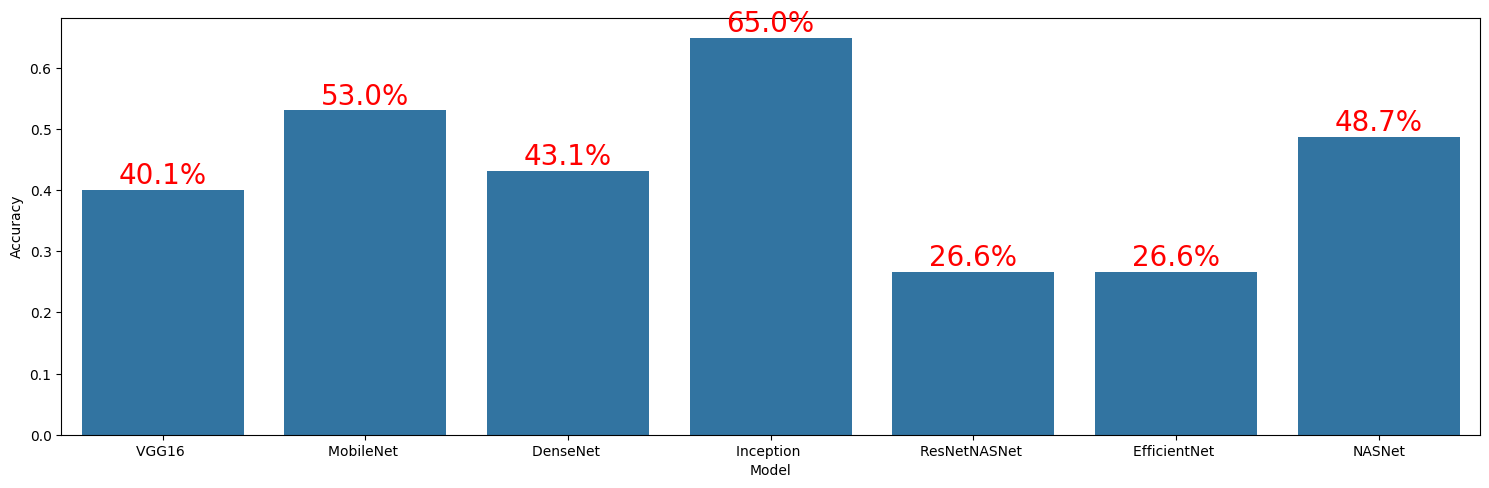

In [45]:
plt.figure(figsize=[15, 5])

# Create bar chart
sns.barplot(x='Model', y='Accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, color ='red', label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=20)

# Adjust the layout
plt.tight_layout()

plt.show()

# Prediction Result Samples

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step


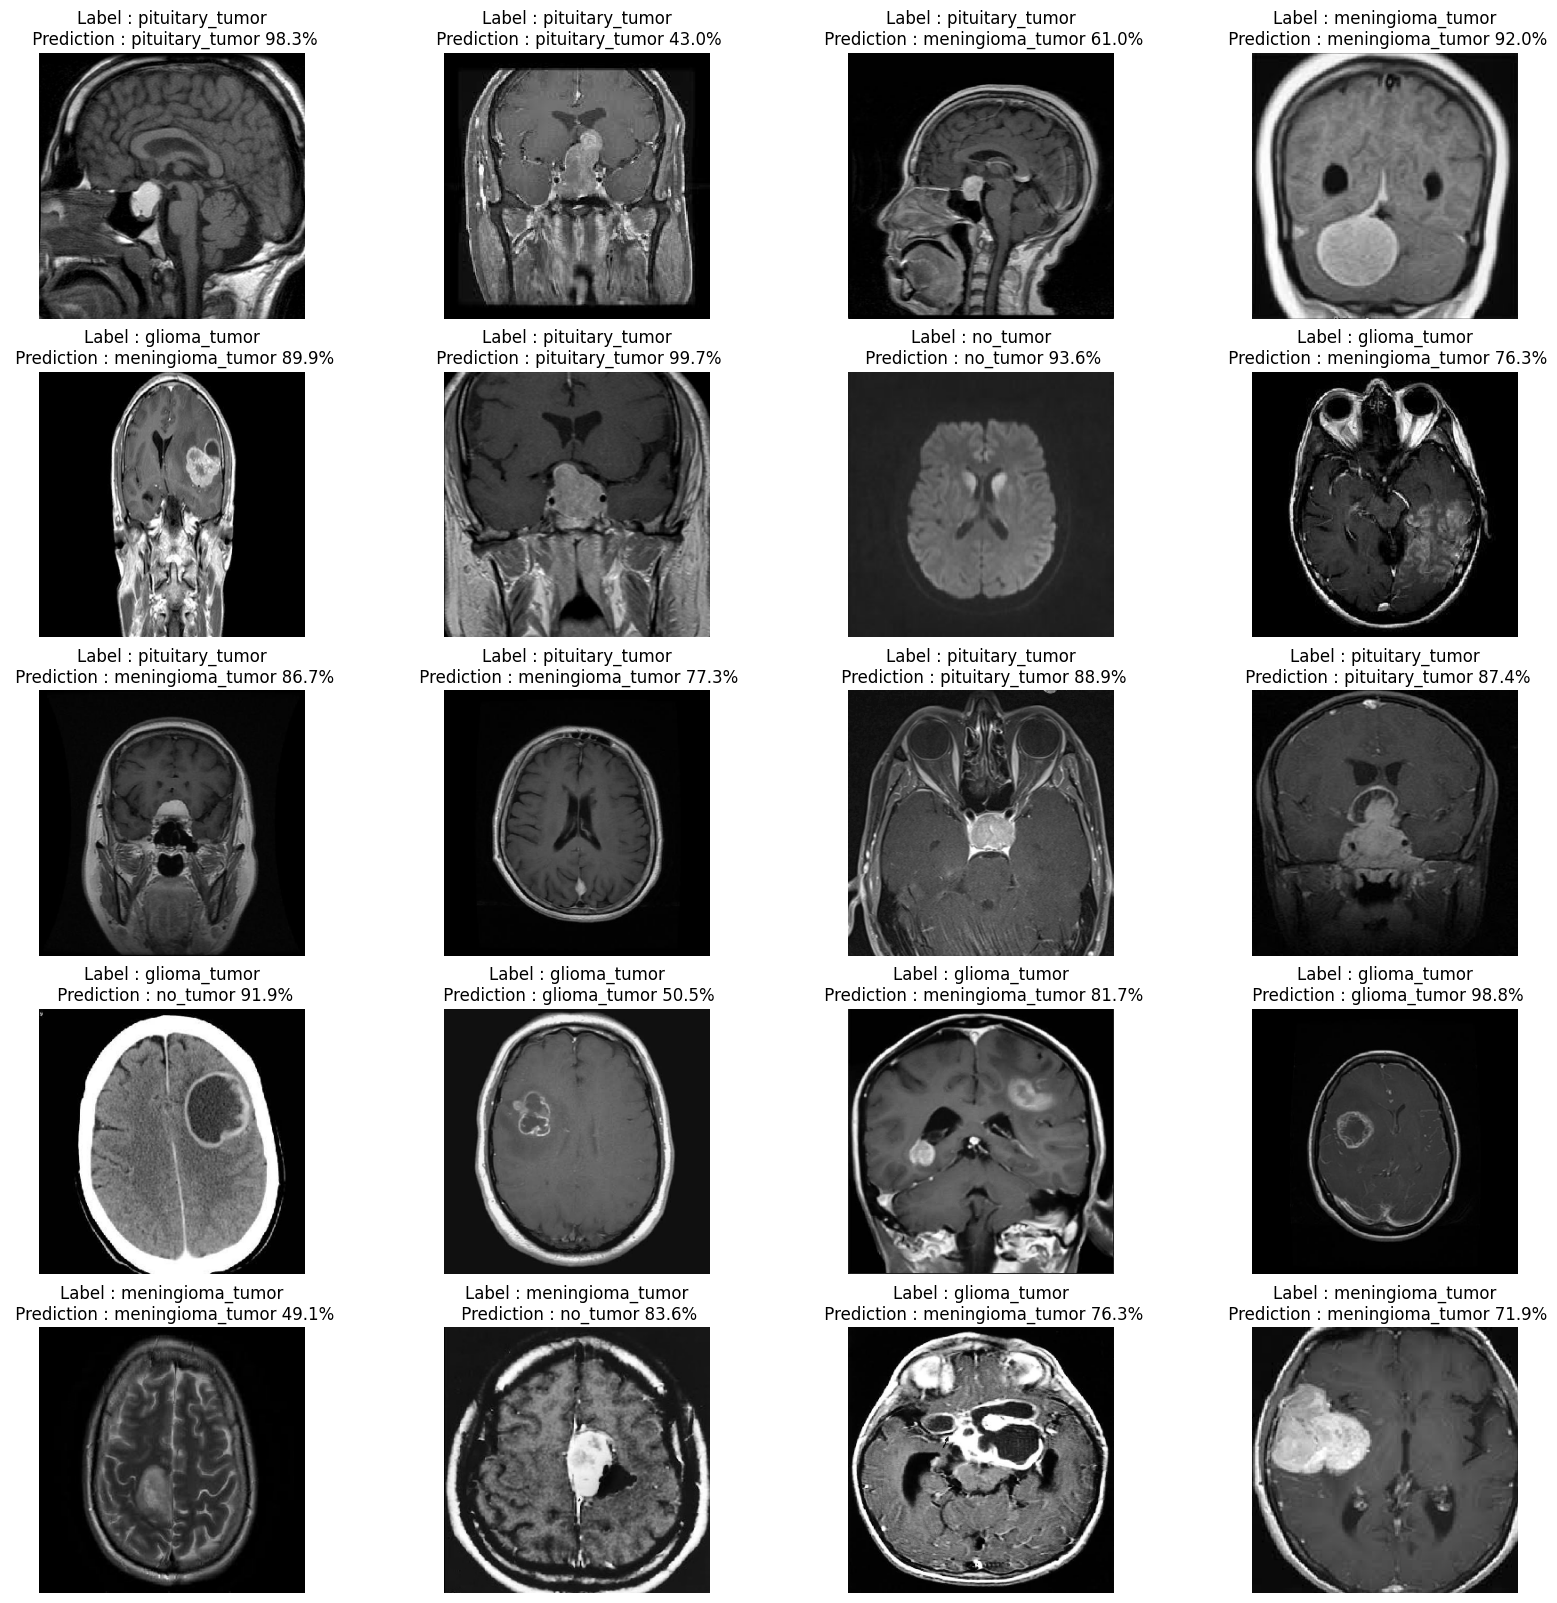

In [46]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 20])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()